## Tissue binary classifier

In this notebook i will generate binary model to distinguish a specific tissue.  
**New in respect to previous all vs all tissue model:**
- one model to binary classify the tissue of each image
- train and validation test keep the balance
- precision and recall per epoch

**Still to implement:**
- Precision, recall at different th to get AUPRC

In [1]:
from CMP_functions.preprocessing import *

import glob
import os
import random 

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

Using TensorFlow backend.


## Data

In [2]:
PATH_info = '../data/images_info_table.csv'
PATH_img = '../data/images_jpeg/'
PATH_folders = '../classification_set/'

In [3]:
#load im info
info_df = pd.read_csv(PATH_info)

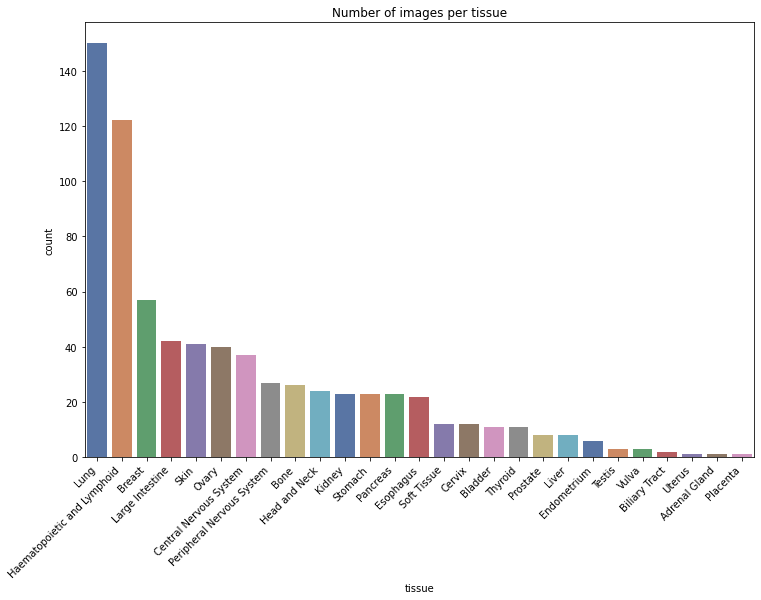

In [4]:
plot_ft_many(info_df, 'tissue')

## Lung vs all

I will first focus on Lung cells because is the most represented class among tissue

In [5]:
#New column containig binary values for lung tissue
info_df['lung'] = np.where(info_df['tissue']=='Lung', '1', '0')

lung images = 150
NOT lung images = 586
negative-positive ratio = 3.9066666666666667


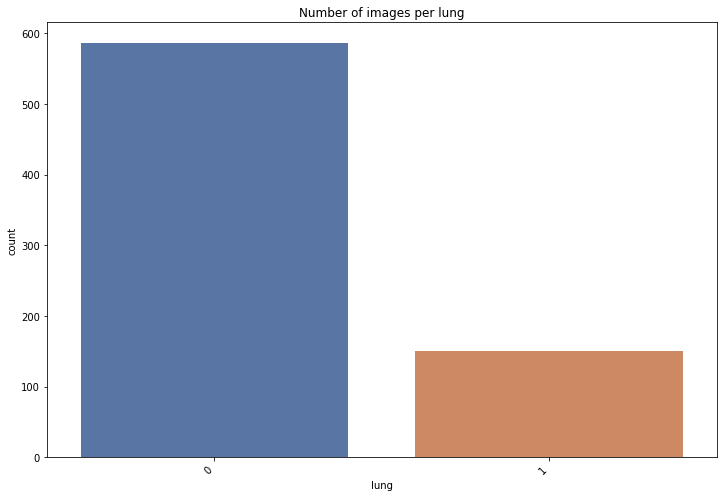

In [6]:
plot_ft_many(info_df, 'lung')
print(f'lung images =', len(info_df[info_df.lung=='1']))
print(f'NOT lung images =',len(info_df[info_df.lung=='0']))
print(f'negative-positive ratio =', len(info_df[info_df.lung=='0'])/len(info_df[info_df.lung=='1']))

In [7]:
len(info_df[info_df.lung=='1'])

150

In [8]:
class_count, class_list = get_classes(info_df, 'lung', ft_min=1)

#here i split the dataset n train and validatio
split = 0.8
all_im = list(info_df.im_id)


#calculate size of positive and negative train and val sets
positive_train_size = round(len(info_df[info_df.lung=='1'])*split)
negative_train_size = round(len(info_df[info_df.lung=='0'])*split)

positive_validation_size = len(info_df[info_df.lung=='1']) - positive_train_size
negative_validation_size = len(info_df[info_df.lung=='0']) - negative_train_size

#randomly select images name

positive_train = random.sample(list(info_df.im_id[info_df.lung=='1']), positive_train_size)
negative_train = random.sample(list(info_df.im_id[info_df.lung=='0']), negative_train_size)

train_im = positive_train + negative_train
validation_im = [im for im in all_im if im not in train_im]

info_df_train = info_df[info_df.im_id.isin(train_im)]
info_df_valid = info_df[info_df.im_id.isin(validation_im)]

#dictionary to be use while linking
name_to_class_train = get_img_dict(info_df_train, class_list,'lung')
name_to_class_valid = get_img_dict(info_df_valid, class_list,'lung')

## Training set

lung images = 120
NOT lung images = 469
negative-positive ratio = 3.908333333333333


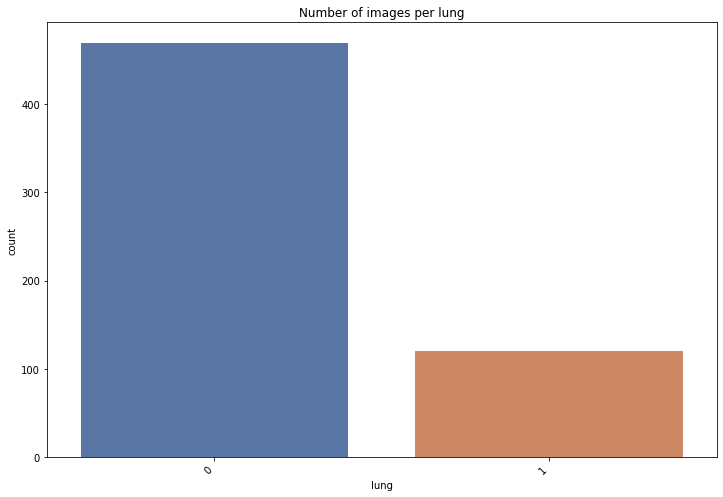

In [9]:
plot_ft_many(info_df_train, 'lung')
print(f'lung images =', len(info_df_train[info_df_train.lung=='1']))
print(f'NOT lung images =',len(info_df_train[info_df_train.lung=='0']))
print(f'negative-positive ratio =', len(info_df_train[info_df_train.lung=='0'])/len(info_df_train[info_df_train.lung=='1']))

## Validation set

lung images = 30
NOT lung images = 117
negative-positive ratio = 3.9


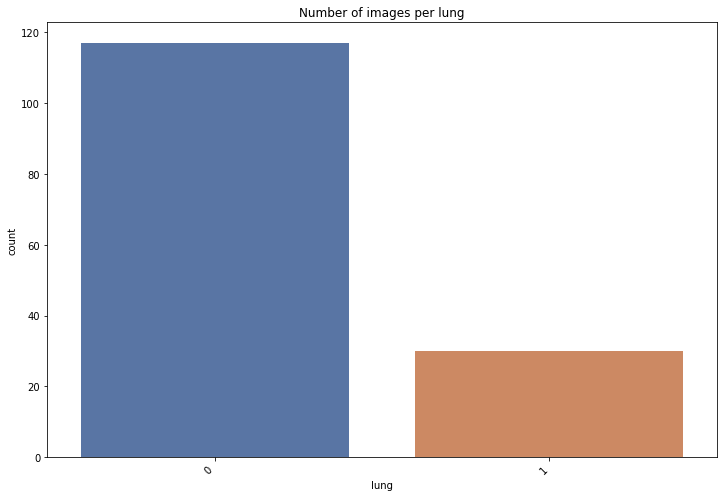

In [10]:
plot_ft_many(info_df_valid, 'lung')
print(f'lung images =', len(info_df_valid[info_df_valid.lung=='1']))
print(f'NOT lung images =',len(info_df_valid[info_df_valid.lung=='0']))
print(f'negative-positive ratio =', len(info_df_valid[info_df_valid.lung=='0'])/len(info_df_valid[info_df_valid.lung=='1']))

In [11]:
# #folders to creates subdir
# os.mkdir(PATH_folders+'train')
# os.mkdir(PATH_folders+'validation')

In [12]:
# create_class_folders2(class_list, PATH_folders+'train/')
# create_class_folders2(class_list, PATH_folders+'validation/')

In [13]:
# link_images(PATH_img, name_to_class_train, PATH_folders+'train/')
# link_images(PATH_img, name_to_class_valid, PATH_folders+'validation/')

## Import of images

In [14]:
datagen = keras.preprocessing.image.ImageDataGenerator()

train = datagen.flow_from_directory('../classification_set/train/', 
                                       class_mode='binary',
                                       batch_size=32)

val = datagen.flow_from_directory('../classification_set/validation/',
                                     class_mode='binary',
                                     batch_size=32)


Found 589 images belonging to 2 classes.
Found 147 images belonging to 2 classes.


## Definition of the model

In [15]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(256, 256, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100))
model.add(Activation("relu"))
model.add(Dense(1))
model.add(Activation("softmax"))

model.compile(optimizer="sgd",
              loss="binary_crossentropy",
              metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

## Training

In [19]:
history = model.fit_generator(
    train,
    steps_per_epoch=22,
    epochs=5,
    validation_data=val,
    validation_steps=22)

Epoch 1/5
22/22 [==============================] - 98s 4s/step - loss: 12.1409 - accuracy: 0.2117 - precision_1: 0.2117 - recall_1: 1.0000 - val_loss: 9.5308 - val_accuracy: 0.2086 - val_precision_1: 0.2086 - val_recall_1: 1.0000
Epoch 2/5
22/22 [==============================] - 93s 4s/step - loss: 12.3112 - accuracy: 0.1942 - precision_1: 0.1942 - recall_1: 1.0000 - val_loss: 11.9135 - val_accuracy: 0.2025 - val_precision_1: 0.2025 - val_recall_1: 1.0000
Epoch 3/5
22/22 [==============================] - 90s 4s/step - loss: 12.2724 - accuracy: 0.2042 - precision_1: 0.2042 - recall_1: 1.0000 - val_loss: 11.9135 - val_accuracy: 0.2019 - val_precision_1: 0.2019 - val_recall_1: 1.0000
Epoch 4/5
22/22 [==============================] - 94s 4s/step - loss: 12.1751 - accuracy: 0.2060 - precision_1: 0.2060 - recall_1: 1.0000 - val_loss: 14.2962 - val_accuracy: 0.1979 - val_precision_1: 0.1979 - val_recall_1: 1.0000
Epoch 5/5
22/22 [==============================] - 90s 4s/step - loss: 12.281

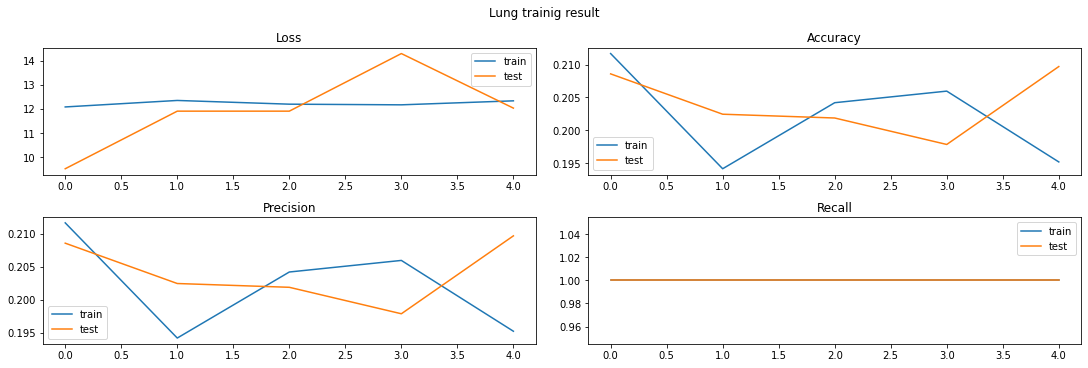

In [38]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(ncols=2, nrows = 2, figsize=(15,5), constrained_layout=True,)

_ = fig.suptitle('Lung trainig result')

_ = ax1.set_title('Loss')
_ = ax1.plot(history.history['loss'], label='train')
_ = ax1.plot(history.history['val_loss'], label='test')
_ = ax1.legend()

_ = ax2.set_title('Accuracy')
_ = ax2.plot(history.history['accuracy'], label='train')
_ = ax2.plot(history.history['val_accuracy'], label='test')
_ = ax2.legend()

_ = ax3.set_title('Precision')
_ = ax3.plot(history.history['precision_1'], label='train')
_ = ax3.plot(history.history['val_precision_1'], label='test')
_ = ax3.legend()

_ = ax4.set_title('Recall')
_ = ax4.plot(history.history['recall_1'], label='train')
_ = ax4.plot(history.history['val_recall_1'], label='test')
_ = ax4.legend()